In [89]:
from dotenv import load_dotenv, find_dotenv
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
load_dotenv(find_dotenv())

True

### Reading the txt files from source directory

In [90]:
loader = DirectoryLoader('./source', glob="./*.txt", loader_cls=TextLoader)
docs = loader.load()

### Creating Chunks using RecursiveCharacterTextSplitter

In [91]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=10,
    length_function=len
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

###  BGE Embddings

In [92]:
from langchain.embeddings import HuggingFaceBgeEmbeddings

model_name = "BAAI/bge-base-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity
embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

### Creating Vectors from the Doc String using Embeddings

In [93]:
vectors = embeddings.embed_documents(doc_strings)

### Creating Retriever using Vector DB

In [94]:
db = Chroma.from_documents(new_docs, embeddings)
retriever = db.as_retriever(search_kwargs={"k": 4})

### UMAP for Visulation of Vector Space along with Query

In [95]:
# ! pip install umap-learn

In [120]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

umap_transformer = umap.UMAP(random_state=0, transform_seed=0).fit(vectors)

/Users/aritra.sen/Aritra/coding/my_llm_app/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [96]:
umap_transformer.transform([vectors[0]])

array([[12.246204 ,  3.7773688]], dtype=float32)

In [97]:
def embed_docs(vectors,umap_transformer):
    """Function to transform the vectors to 2 dimnesional vectors using UMAP"""
    return np.array([umap_transformer.transform([vector])[0] for vector in vectors])

In [121]:
### Base UPMAP vectors for all the chunks
base_umap_vectors = embed_docs(vectors=vectors,umap_transformer=umap_transformer)

### Embedding Visualization

(8.223255252838134, 13.836990261077881, -4.899656009674072, 4.535670948028565)

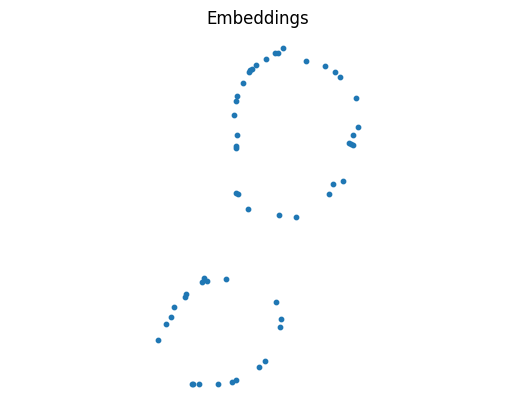

In [99]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(base_umap_vectors[:, 0], base_umap_vectors[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Embeddings')
plt.axis('off')

### Function to Visualize the embeddings with the Query

In [100]:
def visualize_query_with_base_embeddings(query, embeddings, retriever, umap_transformer, base_umap_vectors):
    q_embedding = embeddings.embed_query(query)

    docs = retriever.get_relevant_documents(query)
    page_contents = [doc.page_content for doc in docs]
    retrieved_documents = embeddings.embed_documents(page_contents)

    query_embeddings = embed_docs([q_embedding], umap_transformer)
    retrieved_embeddings = embed_docs(retrieved_documents, umap_transformer)

    plt.figure()
    plt.scatter(base_umap_vectors[:, 0], base_umap_vectors[:, 1], s=10, color='gray')
    plt.scatter(query_embeddings[:, 0], query_embeddings[:, 1], s=150, marker='X', color='r')
    plt.scatter(retrieved_embeddings[:, 0], retrieved_embeddings[:, 1], s=50, facecolors='none', edgecolors='g')
    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{query}')
    plt.axis('off')
    plt.show()

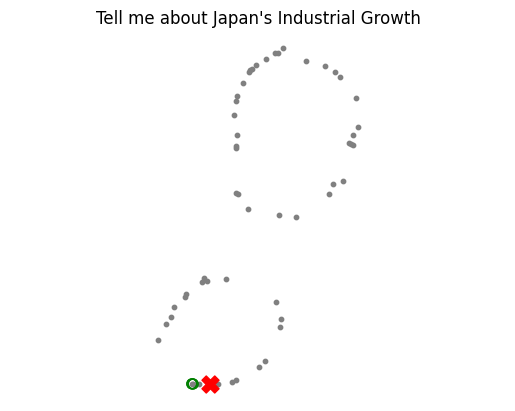

In [101]:
visualize_query_with_base_embeddings("Tell me about Japan's Industrial Growth", embeddings, retriever, umap_transformer, base_umap_vectors)

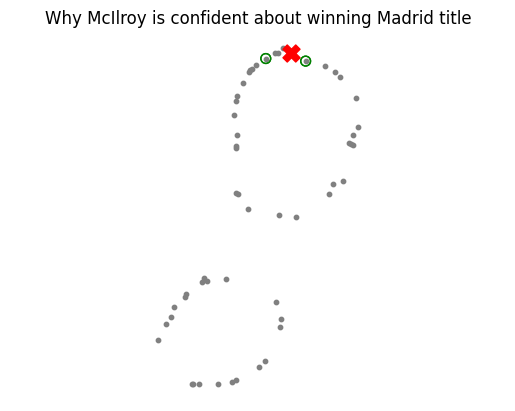

In [102]:
visualize_query_with_base_embeddings("Why McIlroy is confident about winning Madrid title", embeddings, retriever, umap_transformer, base_umap_vectors)

### Importing Togther API Mistal Model using the utils

In [103]:
from utils.llm import LLM

In [104]:
llm = LLM().get_llm_together()

### Pydantic Parser

In [105]:
from langchain.output_parsers import PydanticOutputParser,ListOutputParser,StructuredOutputParser
from langchain.schema.output_parser import StrOutputParser
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List


class LineList(BaseModel):
    lines: list[str] = Field(description="Lines of text")


class LineListOutputParser(PydanticOutputParser):
    def __init__(self) -> None:
        super().__init__(pydantic_object=LineList)

    def parse(self, text: str) -> list[str]:
        lines = text.strip().split("\n")
        return lines


output_parser = LineListOutputParser()

### Query Rewriter or Augmented Queries

In [106]:
def query_rewrite(question:str):
    
    template="""You are an AI language model assistant. Your task is to generate five
    different versions of the given user question to retrieve relevant documents from a vector
    database. By generating multiple perspectives on the user question, your goal is to help
    the user overcome some of the limitations of the distance-based similarity search.
    Provide these alternative questions separated by newlines. 
    Original question: {question}
    Only provide the query, do not do numbering at the start of the questions.
    """


    prompt = ChatPromptTemplate.from_template(template)

    #output_parser = ListOutputParser

    chain = prompt | llm | output_parser

    result = chain.invoke({"question" : question})
    return result

In [ ]:
query = "Tell me about Japan's Industrial Growth"

In [107]:
augmented_queries = query_rewrite(query)

In [109]:
augmented_queries

["1. What are the key factors that contributed to Japan's industrial development?",
 "    2. Describe the historical evolution of Japan's industrial sector.",
 "    3. Provide an overview of Japan's industrial achievements throughout history.",
 "    4. Discuss the major milestones in Japan's industrial progression.",
 '    5. Explain the significant industrial transformations Japan has undergone.']

In [110]:
import re

pattern = r'[0-9]'

aug_queries = []
for line in augmented_queries:
    aug_queries.append(re.sub(pattern, '', line).replace('.','').strip())

aug_queries 


["What are the key factors that contributed to Japan's industrial development?",
 "Describe the historical evolution of Japan's industrial sector",
 "Provide an overview of Japan's industrial achievements throughout history",
 "Discuss the major milestones in Japan's industrial progression",
 'Explain the significant industrial transformations Japan has undergone']

### Retrieve the docouments for Augmented Queries

In [111]:
docs = [retriever.get_relevant_documents(query) for query in aug_queries]

### Removal of Duplicate Documents

In [112]:
unique_contents = set()
unique_docs = []
for sublist in docs:
    for doc in sublist:
        if doc.page_content not in unique_contents:
            unique_docs.append(doc)
            unique_contents.add(doc.page_content)
unique_contents = list(unique_contents)

### Cross Encoder

In [113]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

### Creation of Query(Original Query) and Doc Pairs

In [114]:
pairs = []
for doc in unique_contents:
    pairs.append([query, doc])

### Getting Scores on Pairs using Cross Encoder

In [115]:
scores = cross_encoder.predict(pairs)
scores

array([ 0.09827161, -4.024235  , -2.9265568 ], dtype=float32)

In [116]:
scored_docs = zip(scores, unique_contents)
sorted_docs = sorted(scored_docs, reverse=True)
sorted_docs

[(0.09827161,
  "Japanese industry is growing faster than expected, boosting hopes that the country's retreat back"),
 (-2.9265568, 'Industrial revival hope for Japan'),
 (-4.024235,
  "exports, normally the engine for Japan's economy in the face of weak domestic demand, had helped")]

### Reranking the documents

In [118]:
reranked_docs = [doc for _, doc in sorted_docs]
reranked_docs

["Japanese industry is growing faster than expected, boosting hopes that the country's retreat back",
 'Industrial revival hope for Japan',
 "exports, normally the engine for Japan's economy in the face of weak domestic demand, had helped"]